## Preprocesado

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('data/reviews_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77406 entries, 0 to 77405
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        77406 non-null  object 
 1   review/score              77406 non-null  float64
 2   review/text               77406 non-null  int64  
 3   Title                     77406 non-null  object 
 4   authors                   77406 non-null  object 
 5   publisher                 77406 non-null  object 
 6   publishedDate             77406 non-null  int64  
 7   categories                77406 non-null  object 
 8   Price                     77406 non-null  float64
 9   conteo                    77406 non-null  int64  
 10  review_helpfulness_up     77406 non-null  int64  
 11  review_helpfulness_total  77406 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.1+ MB


In [9]:
df.head(3)

,Id,review/score,review/text,Title,authors,publisher,publishedDate,categories,Price,conteo,review_helpfulness_up,review_helpfulness_total
0,0312267932,4.0,620,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0
1,0312267932,5.0,146,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0
2,0312267932,4.0,429,When All Hell Breaks Loose,"['Cody Lundin', 'Russell Miller']",Gibbs Smith Publishers,2007,Health & Fitness,13.25,126,0,0


### Preprocesado para Precio

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# preprocesado para Precio
pipeline_price = Pipeline([
    (
        'onehot-log',
        ColumnTransformer(
            transformers=[
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                        ),
                        ['publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                ),
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text','review/score', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['authors', 'Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )
])

df_cod_price = pipeline_price.fit_transform(df)

d:\Python\Python310\venvs\py310_iar\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [11]:
df_cod_price.head(5)

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,"publisher_""O'Reilly Media, Inc.""",publisher_Ags Pub,publisher_Amber House Books,publisher_Amereon Limited,...,categories_Religion,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction,Price
0,0.415234,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
1,-1.113057,0.657171,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
2,0.025396,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
3,-0.078165,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25
4,-1.500682,-0.140123,-0.623558,-0.888768,-1.014195,0.138193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.25


### Preprocesado para Rating

In [12]:

from sklearn.preprocessing import FunctionTransformer
import ast

def transform_authors(authors_column):
    authors_column['authors'] = authors_column['authors'].apply(ast.literal_eval)
    authors_column['authors'] = authors_column['authors'].apply(lambda x: ', '.join(x))
    dummies = pd.get_dummies(authors_column['authors'].apply(lambda x: x.split(', ')).apply(pd.Series))
    return dummies
    # return authors_column

authors_transformer = FunctionTransformer(transform_authors, validate=False)

pipeline_rating = Pipeline([
    (
        'one-hot-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'authors',
                    authors_transformer,  # Usa el transformer personalizado para 'authors'
                    ['authors']
                ),
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                    ),
                    ['publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text', 'Price', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'rating-to-int',
        ColumnTransformer(
            transformers=[
                (
                    'rating-to-int',
                     FunctionTransformer(lambda x: x.astype(int), validate=False),
                    ['review/score']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )

])

df_cod_rating = pipeline_rating.fit_transform(df)

d:\Python\Python310\venvs\py310_iar\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [13]:
df_cod_rating.head(5)

,review/score,review/text,Price,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,0_Agatha Christie,0_Alexander Elder,0_Alexander McCall Smith,...,categories_Reference,categories_Religion,categories_Science,categories_Self-Help,categories_Social Science,categories_Sports & Recreation,categories_Technology & Engineering,categories_True Crime,categories_Young Adult Fiction,categories_Young Adult Nonfiction
0,4,0.415234,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,5,-1.113057,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,4,0.025396,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,4,-0.078165,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,4,-1.500682,-0.353991,-0.623558,-0.888768,-1.014195,0.138193,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_cod_rating.dtypes

review/score                             int32
review/text                            float64
Price                                  float64
conteo                                 float64
review_helpfulness_up                  float64
                                        ...   
categories_Sports & Recreation           uint8
categories_Technology & Engineering      uint8
categories_True Crime                    uint8
categories_Young Adult Fiction           uint8
categories_Young Adult Nonfiction        uint8
Length: 605, dtype: object

In [15]:
clases_rating = df_cod_rating['review/score'].unique()
clases_rating

array([4, 5, 3, 2, 1])

## Separacion de los datos de entrenamiento

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import time

### Separacion para Hipotesis Precio

In [17]:
df_price_train, df_price_val = train_test_split(df_cod_price, test_size=0.25, random_state=42, stratify=df_cod_price['Price'])

In [18]:
X_price_train = df_price_train.drop(columns='Price')
Y_price_train = df_price_train['Price']

X_price_val = df_price_val.drop(columns='Price')
Y_price_val = df_price_val['Price']

### Separacion para Hipotesis Rating

In [19]:
df_rating_train, df_rating_val = train_test_split(df_cod_rating, test_size=0.25, random_state=42, stratify=df_cod_rating['review/score'])

In [20]:
X_rating_train = df_rating_train.drop(columns='review/score')
Y_rating_train = df_rating_train['review/score']

X_rating_val = df_rating_val.drop(columns='review/score')
Y_rating_val = df_rating_val['review/score']

In [21]:
clases_rating = df_rating_train['review/score'].unique()
clases_rating

array([4, 5, 3, 1, 2])

### Entrenamiento para Hipotesis Rating

In [22]:
rf_rating = RandomForestClassifier(n_estimators = 120, max_depth = 15, class_weight = 'balanced')
start = time.time()
rf_rating.fit(X_rating_train, Y_rating_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end-start} segundos")

Tiempo de entrenamiento: 17.54558515548706 segundos


In [23]:
predicciones_train_rating = rf_rating.predict(X_rating_train)

In [24]:
accuracy_train_rating = accuracy_score(Y_rating_train, predicciones_train_rating)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_rating:.2f}')

Exactitud en los datos de entrenamiento: 0.60


In [25]:
predicciones_val_rating = rf_rating.predict(X_rating_val)

In [26]:
accuracy_val_rating = accuracy_score(Y_rating_val, predicciones_val_rating)
print(f'Exactitud en los datos de validacion: {accuracy_val_rating:.2f}')

Exactitud en los datos de validacion: 0.49


### Entrenamiento para Hipotesis Precio

In [28]:
from sklearn.neural_network import MLPRegressor

start = time.time()
mlp_precio = MLPRegressor(hidden_layer_sizes=(20,20,20), max_iter=400, activation='logistic', alpha=0.001,  random_state=17)
mlp_precio.fit(X_price_train, Y_price_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end-start}")

Tiempo de entrenamiento: 149.588858127594


In [ ]:
predicciones_train_price = mlp_precio.predict(X_price_train)
mse_price = mean_squared_error(Y_price_train, predicciones_train_price)
print(f'Error cuadrático medio: {mse_price:.2f}')

Error cuadrático medio: 0.00


## Validación de los modelos entrenados

### Validación del modelo para la hipótesis Rating

In [ ]:
predicciones_val_rating = rf_rating.predict(X_rating_val)
accuracy_val_rating = accuracy_score(Y_rating_val, predicciones_val_rating)
print(f'Exactitud en los datos de validación: {accuracy_val_rating:.2f}')

Exactitud en los datos de validación: 0.52


In [ ]:
confusion_rating = confusion_matrix(Y_rating_val, predicciones_val_rating)
print("Matriz de Confusión:")
print(confusion_rating)

Matriz de Confusión:
[[ 500  126   41   44   73]
 [ 153  118   75   65   87]
 [ 102  101  106  207  225]
 [  79  115  119  649  625]
 [ 255  176  252 1153 2993]]


In [ ]:
type(clases_rating)

numpy.ndarray

In [ ]:
clases_rating.shape

(5,)

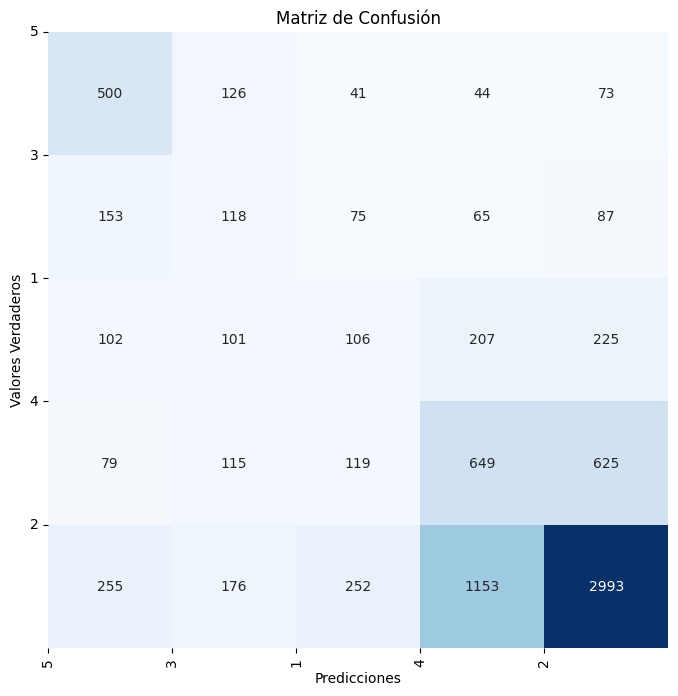

In [ ]:
plot_confusion_matrix(confusion_rating, 8, 8, clases_rating.tolist())

### Validación del modelo para la hipótesis Precio

In [ ]:
predicciones_val_price = mlp_precio.predict(X_price_val)
mse_price_val = mean_squared_error(Y_price_val, predicciones_val_price)
mae_price_val = mean_absolute_error(Y_price_val, predicciones_val_price)
r2_price_val = r2_score(Y_price_val, predicciones_val_price)
rmse_price_val = np.sqrt(mse_price_val)
medae_prive_val = median_absolute_error(Y_price_val, predicciones_val_price)
print(f'Error cuadrático medio: {mse_price_val:.2f}')
print(f'Error absoluto medio: {mae_price_val:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_val:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_val:.2f}')
print(f"Error Absoluto mediano: {medae_prive_val}") #Menos suceptible a valores extremos que el MAE

Error cuadrático medio: 0.00
Error absoluto medio: 0.01
R-squared (variabilidad capturada): 1.00
Raiz cuadrada del MSE: 0.02
Error Absoluto mediano: 0.007427258126181613


In [ ]:
predicciones_val_price_df = pd.DataFrame({'Predicciones': predicciones_val_price})
predicciones_val_price_concat_df = pd.concat([df_price_val.reset_index(drop=True), predicciones_val_price_df], axis=1)
predicciones_val_price_concat_df.head(10)


,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,authors_Ben Mezrich,...,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,Price,Predicciones
0,-1.623252,0.694733,0.171524,-0.794639,-0.918971,0.506549,0,0,0,0,...,0,0,0,0,0,0,0,0,19.25,19.265311
1,-1.599232,-2.351318,-0.578874,0.975785,1.954333,0.095102,0,0,0,0,...,0,0,0,0,0,0,0,0,35.50,35.546535
2,1.299175,-0.828292,-0.599760,-0.109746,0.018472,-0.522070,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.805518
3,0.588198,0.694733,-0.599760,-0.794639,-0.918971,-0.522070,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.804474
4,-0.057139,0.694733,-0.786241,-0.794639,-0.918971,0.095102,0,0,0,0,...,0,0,0,0,0,0,0,0,20.86,20.809614
5,0.538756,-0.066780,-0.192486,0.290891,0.018472,0.660842,1,0,0,0,...,0,0,0,0,0,1,0,0,108.00,107.994376
6,-0.017204,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,10.19,10.184903
7,-1.394973,-0.828292,0.167049,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,5.99,5.991150
8,2.077203,0.694733,-0.108943,0.290891,0.018472,-0.419208,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.803593
9,-1.404784,0.694733,-0.182043,-0.794639,-0.918971,0.403687,0,0,0,0,...,0,0,0,0,0,0,0,0,4.99,4.991372


In [ ]:
tamano_submuestra = 300  # Puedes ajustar esto al tamaño deseado

# Crea una submuestra aleatoria del DataFrame
submuestra_aleatoria = predicciones_val_price_concat_df.sample(n=tamano_submuestra, random_state=23)
submuestra_aleatoria

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,authors_Ben Mezrich,...,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,Price,Predicciones
4323,2.220981,0.694733,-0.680320,-0.794639,-0.918971,0.455118,0,0,0,0,...,0,0,0,0,0,0,0,0,24.15,24.167688
6495,-1.519259,0.694733,-0.182043,-0.109746,0.018472,0.403687,0,0,0,0,...,0,0,0,0,0,0,0,0,4.99,4.991565
3258,0.589661,0.694733,0.171524,0.795635,0.609932,0.506549,0,0,0,0,...,0,0,0,0,0,0,0,0,19.25,19.260031
4752,0.153517,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,10.19,10.184619
2495,1.640096,-0.066780,-0.176076,0.795635,0.454358,-0.110622,0,0,0,0,...,0,0,0,0,0,0,0,0,10.85,10.852942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,0.709636,-0.066780,-0.596777,-0.794639,-0.918971,0.197964,0,0,0,0,...,0,0,0,0,0,0,0,0,14.93,14.932462
1529,-1.114104,0.694733,0.969662,-0.794639,-0.918971,-0.573501,0,0,0,0,...,0,0,0,0,0,0,0,0,14.02,14.025157
2822,1.398760,-2.351318,-0.742978,0.290891,0.741469,0.352256,0,0,0,0,...,0,0,0,0,0,0,0,0,10.88,10.883328
287,-0.431749,0.694733,-0.404328,1.812994,1.446871,0.197964,0,0,0,0,...,0,0,1,0,0,0,0,0,18.46,18.496314
